In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import pyarrow.parquet as pq
import pyarrow as pa
import glob
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
import dask
from collections import Counter
from tqdm import tqdm, tqdm_notebook
import os
import pickle
# from numba import jit

In [2]:
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

# <font color='blue'> Загрузка данных

In [3]:
dataset_dir = r'/home/protus/Documents/DATASETS/ML_Boot_camp/Colaborative filtering'
train_col_dirs = glob.glob(dataset_dir+'/train/date*')
SERIALIZED_DIR = './serialized'

In [4]:
def load_run(func_name, file_name=None, *args):
    """Функция повторного запуска
    Позволяет при первом обращении к указанной функции расчитать и сериализовать её ответ,
    и при последующих обращениях загружать уже расчитанные сериализованные значения.
    
    Удобно при работе с функциями требующими длительного времени выполнения"""

    if file_name:
        file = SERIALIZED_DIR+'/'+file_name+'.pcl'
    else:
        file = SERIALIZED_DIR+'/'+func_name.__name__+'.pcl'
        
    if os.path.isfile(file):
        with open(file, 'rb') as f:
            return pickle.load(f)
    else:
        res = func_name(*args)
        with open(file , 'wb') as f:
            pickle.dump(res, f)
        return res

In [5]:
client = Client(n_workers=4, threads_per_worker=2, processes=False, memory_limit='20GB')
client

Client Scheduler: inproc://192.168.1.132/9870/1 Dashboard: http://localhost:8787/status,Cluster Workers: 4 Cores: 8 Memory: 80.00 GB


In [6]:
get_dd_column = lambda column: dd.read_parquet(dataset_dir+'/train/date*/*.parquet', columns=column, engine='pyarrow')
get_dd_column_unique = lambda column: get_dd_column([column])[column].unique().compute()

In [7]:
train_dataset = dd.read_parquet(dataset_dir+'/train/date*/*.parquet', engine='pyarrow')

def dataset_length_calc(dataset):
    return len(dataset)
    
datset_size = load_run(dataset_length_calc, None, train_dataset)
print('Размер датасета {0:,}, кол-во столбцов {1}'.format(datset_size, len(train_dataset.columns)))

Размер датасета 30,787,847, кол-во столбцов 106


# <font color='blue'>Анализ типов колонок
выделяем колонки содержащие 
- дату и время, 
- категориальные
- числовые
- вложенные коллекции
- NaN-ы
- ссылки и ключи

### Анализ пропущенных значений

In [8]:
def nans_map(train_col_dirs, column_count):

    def nans_partition_calc(files_dir):
        """Аггрегация кол-ва NaNов в ячейки
        
        Значения столбца делятся на непересекающиеся ячейки,
        все значения ячейки аггрегируются в одно
        """
        
        output_size = 100 #кол-во значений в ячейке
        part = pq.read_table(files_dir+'/').to_pandas()
        part = part.isna()
        cell_size = len(part)//output_size
        NaNs = np.zeros((output_size, part.shape[1]))

        for i, cell in enumerate(range(cell_size, len(part), cell_size)):
            NaNs[i, :] = part.loc[cell-cell_size:cell,:].sum()

        return NaNs

    NaNs = np.zeros((0, column_count))
    #проход по разделам - файлам датасета
    for partition in tqdm_notebook(train_col_dirs):
        NaNs = np.append(NaNs, nans_partition_calc(partition), axis=0)     

    NaNs /= NaNs.max()
    
    return NaNs


def plot_NANs_map(NaNs, size=(10, 20)):
    plt.figure(figsize=size)
    plt.imshow(NaNs.T, cmap='gray', vmin=0, vmax=1)
    _ = plt.title('Карта интенсивности распределения NaN-ов по датасету')

    
NaNs = load_run(nans_map, None, train_col_dirs, len(train_dataset.columns))

### Карта интенсивности распределения NaN-ов по датасету

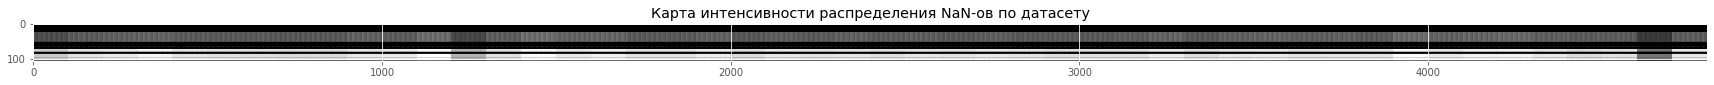

In [9]:
plot_NANs_map(NaNs, size=(30, 20))

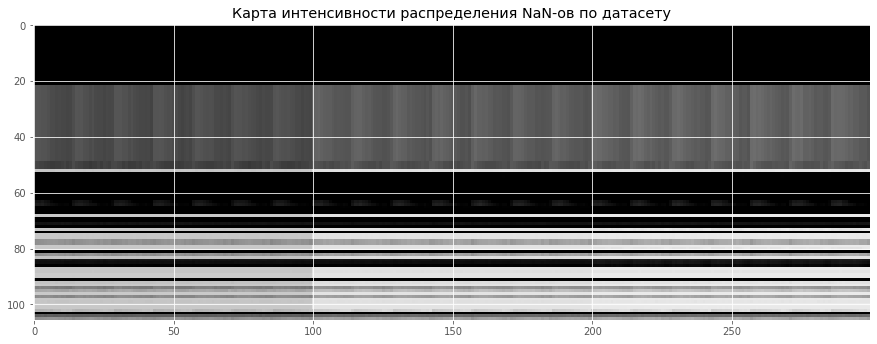

In [10]:
plot_NANs_map(NaNs[:300], size=(15, 20))

- видим, что в распределении пропущенных значений есть цикличность, а значит есть полезная структура
- в то время как некоторые колонки содержат большое кол-во пропущенных значений
- более светлые значения отражают большую интенсивность

In [11]:
def NaNs_columns_calc(dataset, datset_size):
    return df(dataset.isna().sum().compute()) / datset_size

NaNs_columns = load_run(NaNs_columns_calc, None, train_dataset, datset_size)
# удаляем колонки с кол-вом нанов > 95%
NaNs_columns = NaNs_columns.loc[NaNs_columns[0]>0.95]
NaNs_columns

,0
membership_joinRequestDate,0.98
auditweights_closed,1.00
auditweights_feedOwner_RECOMMENDED_GROUP,0.99
auditweights_friendCommentFeeds,0.99
auditweights_friendCommenters,0.99
auditweights_hasDetectedText,1.00
auditweights_hasText,0.99
auditweights_notOriginalPhoto,0.97
auditweights_onlineVideo,1.00
auditweights_processedVideo,0.98


In [12]:
print('Кол-во колонок с пропущенными значениями более 95% -', len(NaNs_columns))

Кол-во колонок с пропущенными значениями более 95% - 19


### Разделяем признаки по типам

In [13]:
Not_NaN_columns = list(set(train_dataset.columns) - set(NaNs_columns.T.columns))
id_columns = list(train_dataset.columns[train_dataset.columns.str.contains('Id|_ID')])
all_columns =  list(set(Not_NaN_columns) - set(id_columns))

object_type_columns = list(train_dataset[all_columns].select_dtypes('object').columns)
not_object_type_columns = list(set(all_columns) - set(object_type_columns))
date_time_columns = train_dataset[all_columns].columns[train_dataset[all_columns].columns.str.lower().str.contains('date|time')]
numeric_columns = list(set(not_object_type_columns) - set(date_time_columns))
date_time_columns

Index(['audit_timestamp', 'audit_timePassed', 'user_change_datime',
       'user_birth_date', 'membership_joinDate', 'user_create_date',
       'membership_statusUpdateDate', 'userOwnerCounters_PHOTO_PIN_UPDATE'],
      dtype='object')

In [14]:
date_time_columns = list(set(date_time_columns)-set(['userOwnerCounters_PHOTO_PIN_UPDATE']))+['metadata_createdAt']
numeric_columns = list(set(not_object_type_columns) - set(date_time_columns))

[TODO]  feature engeneering user_birth_date: разложить на год, месяц, день, посчитать относительное время

### Удаляем бесполезные колонки, т.е. те которые содержат одно и тоже значение

In [15]:
def get_numeric_column_mean_max():
    d = dd.read_parquet(dataset_dir+'/train/date*/*.parquet', engine='pyarrow', columns=numeric_columns).fillna(0)
    return dask.compute(d.mean(), d.max())

numeric_column_mean, numeric_column_max = load_run(get_numeric_column_mean_max)

In [16]:
useless_numeric_columns = train_dataset[numeric_columns].columns[numeric_column_mean == numeric_column_max]
useless_numeric_columns

Index(['auditweights_ctr_negative', 'user_is_semiactivated',
       'auditweights_likersSvd_hyper', 'metadata_numSymbols',
       'userOwnerCounters_COMMENT_INTERNAL_LIKE',
       'auditweights_likersFeedStats_hyper', 'auditweights_x_ActorsRelations',
       'user_is_activated', 'user_region', 'userOwnerCounters_CREATE_IMAGE',
       'auditweights_feedStats', 'audit_pos',
       'userOwnerCounters_PHOTO_PIN_BATCH_CREATE',
       'userOwnerCounters_USER_PRESENT_SEND', 'auditweights_friendLikes',
       'auditweights_dailyRecency', 'userOwnerCounters_CREATE_MOVIE',
       'userOwnerCounters_USER_SEND_MESSAGE'],
      dtype='object')

In [17]:
numeric_columns = list(set(numeric_columns) - set(useless_numeric_columns))

### Проверка вложенных признаков

In [18]:
temp_ds = pq.read_table(train_col_dirs[0]+'/').to_pandas() #возмем один раздел чтобы не обращаться ко всему датасету
columns_with_nested_types = [isinstance(temp_ds[col][10], np.ndarray) for col in object_type_columns]
columns_with_nested_types = list(train_dataset[object_type_columns].columns[columns_with_nested_types])
columns_with_nested_types

['feedback', 'metadata_options']

In [19]:
category_columns = list(set(object_type_columns) - set(columns_with_nested_types))
category_columns

['metadata_platform',
 'membership_status',
 'metadata_ownerType',
 'audit_clientType']

In [20]:
id_columns

['instanceId_userId',
 'instanceId_objectType',
 'instanceId_objectId',
 'metadata_ownerId',
 'metadata_authorId',
 'metadata_applicationId',
 'user_ID_country',
 'user_ID_Location',
 'ImageId']

In [21]:
date_time_columns

['audit_timestamp',
 'user_create_date',
 'audit_timePassed',
 'user_change_datime',
 'membership_statusUpdateDate',
 'user_birth_date',
 'membership_joinDate',
 'metadata_createdAt']

In [22]:
numeric_columns

['auditweights_userOwner_TEXT',
 'userOwnerCounters_CREATE_LIKE',
 'userOwnerCounters_VOTE_POLL',
 'userOwnerCounters_USER_PROFILE_VIEW',
 'userOwnerCounters_USER_DELETE_MESSAGE',
 'userOwnerCounters_TEXT',
 'userOwnerCounters_PHOTO_MARK_CREATE',
 'auditweights_numDislikes',
 'auditweights_ageMs',
 'auditweights_numLikes',
 'userOwnerCounters_PHOTO_VIEW',
 'auditweights_userOwner_IMAGE',
 'auditweights_userOwner_CREATE_LIKE',
 'user_gender',
 'auditweights_ctr_gender',
 'user_is_abused',
 'userOwnerCounters_USER_INTERNAL_UNLIKE',
 'metadata_numPhotos',
 'metadata_numCompanions',
 'userOwnerCounters_USER_FORUM_MESSAGE_CREATE',
 'userOwnerCounters_USER_STATUS_COMMENT_CREATE',
 'userOwnerCounters_VIDEO',
 'metadata_totalVideoLength',
 'auditweights_userAge',
 'user_is_active',
 'auditweights_numShows',
 'metadata_numTokens',
 'auditweights_friendLikes_actors',
 'userOwnerCounters_IMAGE',
 'metadata_numPolls',
 'userOwnerCounters_PHOTO_PIN_UPDATE',
 'userOwnerCounters_UNKNOWN',
 'auditweig

#### Выводы:
- отброшены признаки большим кол-вом пропусков > 95%, это 19 признаков
- выделены признаки описания даты и времени
- выделены категориальные признаки
- выделены числовые признаки
- выделены колонки с вложенными коллекциями

# <font color='blue'>Описательные статистики

In [23]:
def compute_dataset_statistics(dataset_path, columns):
    
    d = dd.read_parquet(dataset_path, engine='pyarrow', columns=columns).fillna(0)
    
    max_val, min_val, mean_val, quantiles = dask.compute(d.max(), 
                                                        d.min(),
                                                        d.mean(),
                                                        d.quantile([0.25, 0.5, 0.75]))
    
    return max_val, min_val, mean_val, quantiles

def box_plot(max_val, min_val, mean_val, quantiles):
    
    stats = []
    for i in range(len(max_val)):
        item = {}
        item["label"] = quantiles.columns[i]
        item["mean"] = mean_val[i]
        item["med"] = quantiles.iloc[1,i]
        item["q1"] = quantiles.iloc[0,i]
        item["q3"] = quantiles.iloc[2,i]
        item["whislo"] = min_val[i]
        item["whishi"] = max_val[i]
        item["fliers"] = []

        stats.append(item)
        
    fig, axes = plt.subplots(1, 1, figsize=(30,10))
    axes.bxp(stats, showmeans=True, meanline=False, patch_artist=True)
    axes.set_title('Распределения числовых признаков по логарифмической шкале')
    plt.yscale('log')
    p = plt.xticks(rotation=90)

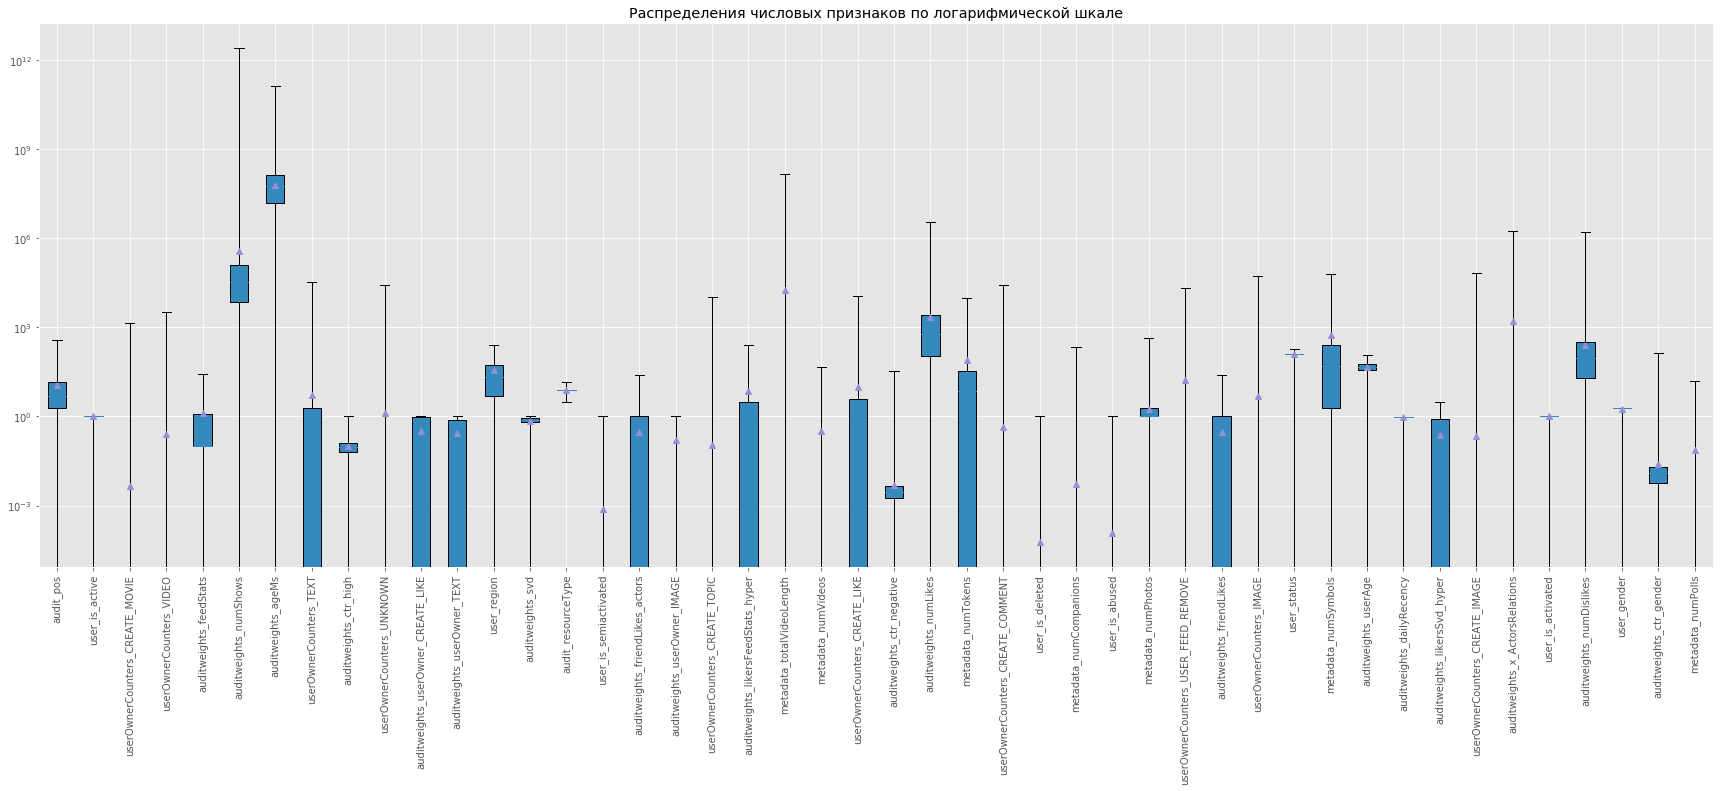

In [24]:
max_val, min_val, mean_val, quantiles = load_run(compute_dataset_statistics, 'train_dataset_stat',
                                                 dataset_dir+'/train/date*/*.parquet', 
                                                 numeric_columns)

box_plot(max_val, min_val, mean_val, quantiles)

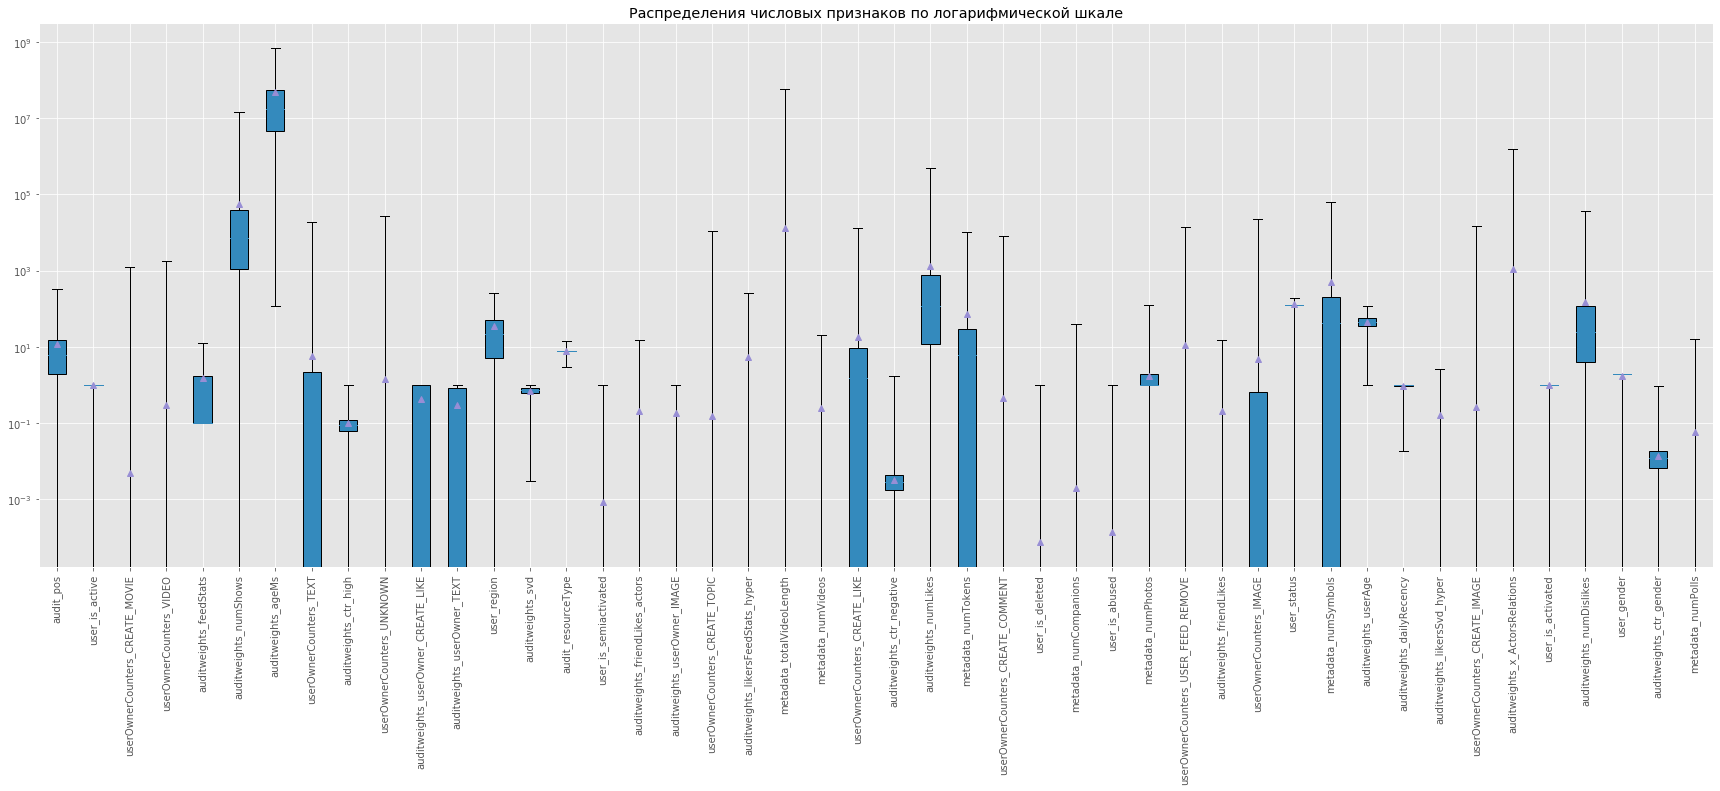

In [25]:
max_val, min_val, mean_val, quantiles = load_run(compute_dataset_statistics, 'test_dataset_stat',
                                                 dataset_dir+'/test/*.parquet', 
                                                 numeric_columns)

box_plot(max_val, min_val, mean_val, quantiles)

In [26]:
find_column_by_name = lambda col_name: train_dataset.columns[train_dataset.columns.str.lower().str.contains(col_name)]

In [27]:
get_dd_column(find_column_by_name('numshow')).max().compute()

auditweights_numShows   2,541,907,350,000.00
dtype: float64

In [28]:
get_dd_column(find_column_by_name('agems')).max().compute()

auditweights_ageMs   133,350,982,000.00
dtype: float64

In [29]:
print("Кол-во уникальных пользователей {0:,}\n\
Кол-во уникальных обьектов {1:,}".format(\
    get_dd_column_unique('instanceId_userId').count(),
    get_dd_column_unique('instanceId_objectId').count()))

Кол-во уникальных пользователей 3,842,244
Кол-во уникальных обьектов 6,323,483


### Статистики по отзывам пользователей

In [30]:
%%time
feedback = get_dd_column(['feedback'])
feedback_unique = set()
temp = feedback['feedback'].map(lambda x: feedback_unique.update(x)).compute()

CPU times: user 1min 19s, sys: 3.41 s, total: 1min 22s
Wall time: 1min 14s


In [31]:
feedback_unique

{'Clicked',
 'Commented',
 'Complaint',
 'Disliked',
 'Ignored',
 'Liked',
 'ReShared',
 'Unliked',
 'Viewed',
 'f',
 'o'}

In [32]:
client.cancel(feedback)
client.cancel(temp)

#### Распределение типов контента

In [33]:
%%time
#распределение типов контента
instanceId_objectTypes = get_dd_column(['instanceId_objectType']).groupby(by='instanceId_objectType')\
    ['instanceId_objectType'].count().compute()
print("Типы контента и частоты {0}".format(instanceId_objectTypes.map("{:,}".format)))

Типы контента и частоты instanceId_objectType
Photo     1,411,216
Post     28,601,793
Video       774,838
Name: instanceId_objectType, dtype: object
CPU times: user 19.1 s, sys: 1.58 s, total: 20.7 s
Wall time: 15.8 s


In [34]:
def plot_counter(counter):
    plt.bar(counter.keys(), counter.values())
    plt.xticks(rotation=45)

#### Распределение количества оценок пользователей по контенту Post

Counter({1: 26535247, 2: 1753288, 3: 294114, 4: 18333, 5: 797, 6: 13, 7: 1})
CPU times: user 49.4 s, sys: 4.02 s, total: 53.4 s
Wall time: 45.5 s


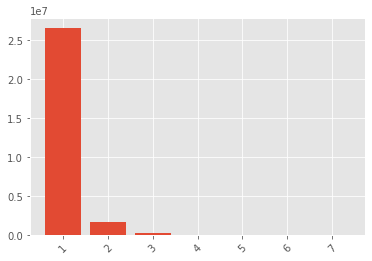

In [35]:
%%time
#выборка по Post типу контента 
data = get_dd_column(['instanceId_objectType', 'feedback'])
post_feedback = data.loc[data.instanceId_objectType=='Post','feedback'].compute()
#распределение кол-ва оценок
f = np.vectorize(lambda x: len(x))
post_feedback_distr = Counter(f(post_feedback))
print(post_feedback_distr)
plot_counter(post_feedback_distr)

#### Распределение оценок пользователей c одной оценкой по обьекту по контенту Post

Counter({'Ignored': 19165862, 'Liked': 4338642, 'None': 2066546, 'Clicked': 1936246, 'Disliked': 982308, 'ReShared': 86724, 'Commented': 25035, 'Unliked': 242, 'Complaint': 188})
CPU times: user 20.1 s, sys: 601 ms, total: 20.7 s
Wall time: 20.4 s


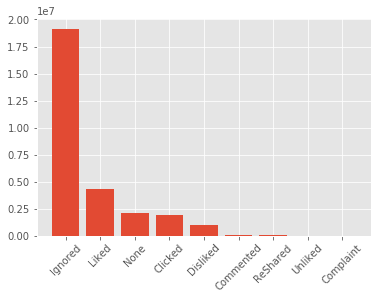

distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://192.168.1.132/9870/34 remote=inproc://192.168.1.132/9870/1>


In [36]:
%%time
def selected_values(x):
    if len(x)==1:
        return x[0]
    
f = np.vectorize(selected_values)
one_feedback_distr = Counter(f(post_feedback))
print(one_feedback_distr)
plot_counter(one_feedback_distr)

In [37]:
print("Доля Liked против остальных (только контент пост с пользователями с 1-ной оценкой) в%", one_feedback_distr['Liked']/sum(one_feedback_distr.values())*100)

Доля Liked против остальных (только контент пост с пользователями с 1-ной оценкой) в% 15.169125935566347


In [38]:
client.cancel(post_feedback)
post_feedback = None

#### Распределение кол-ва оценок на одного пользователя?

In [39]:
user_values = get_dd_column(['instanceId_userId', 'feedback']).\
                groupby('instanceId_userId')['instanceId_userId'].count().compute()
#кол-во оценок на одного пользователя
user_values = Counter(user_values)
user_values.most_common()

[(2, 660260),
 (3, 530520),
 (1, 514334),
 (4, 388124),
 (5, 286639),
 (6, 219090),
 (7, 171311),
 (8, 137405),
 (9, 111302),
 (10, 92202),
 (11, 77588),
 (12, 65284),
 (13, 55571),
 (14, 48551),
 (15, 41552),
 (16, 36963),
 (17, 32632),
 (18, 28749),
 (19, 25611),
 (20, 22690),
 (21, 20693),
 (22, 18545),
 (23, 16933),
 (24, 15319),
 (25, 13907),
 (26, 12424),
 (27, 11597),
 (28, 10784),
 (29, 9862),
 (30, 9054),
 (31, 8363),
 (32, 7652),
 (33, 7234),
 (34, 6641),
 (35, 6255),
 (36, 5868),
 (37, 5454),
 (38, 5041),
 (39, 4731),
 (40, 4398),
 (41, 4238),
 (42, 3927),
 (43, 3653),
 (44, 3622),
 (45, 3311),
 (46, 3121),
 (47, 2907),
 (48, 2799),
 (49, 2652),
 (50, 2504),
 (51, 2484),
 (52, 2182),
 (53, 2116),
 (54, 1972),
 (55, 1923),
 (56, 1912),
 (57, 1678),
 (58, 1649),
 (59, 1574),
 (60, 1510),
 (62, 1417),
 (61, 1408),
 (63, 1302),
 (64, 1240),
 (65, 1217),
 (66, 1190),
 (67, 1155),
 (68, 1093),
 (69, 1061),
 (70, 1002),
 (72, 920),
 (71, 902),
 (73, 891),
 (75, 816),
 (74, 792),
 (

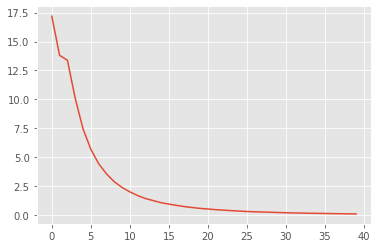

In [40]:
#кол-во оценок на %пользователей
user_activity = list(zip(*user_values.most_common()))
perc = np.array(user_activity[1])/np.array(user_activity[1]).sum()*100
p = plt.plot(perc[:40])

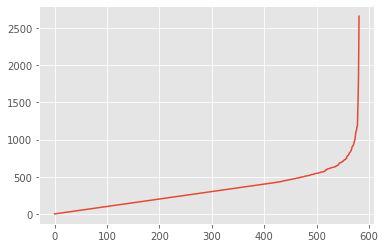

In [41]:
#Кол-во оценок на категории пользователей
user_act = list(user_activity[0])
user_act.sort()
p = plt.plot(user_act)

In [42]:
print("% пользователей с кол-вом оценок от 1 до 5: ", sum(perc[:4]))

% пользователей с кол-вом оценок от 1 до 5:  54.47956975142651


- Преобладающее большинство пользователей ставят от 1 до 3-х оценок
- Более 50% пользователей ставят от 1 до 5 оценок.
- Большинство пользователей - 17% ставят 2 оценки
- Есть пользователи с аномальным кол-вом оценок больше 1000 -видимо это боты

### Анализ активности пользователей по времени

In [43]:
%%time
from datetime import datetime, date

def date_time_decomposition():
    user_date_time = get_dd_column(['audit_timestamp', 'instanceId_userId'])
    user_date_time['audit_timestamp'] = user_date_time['audit_timestamp']\
                    .map(lambda x:  datetime.fromtimestamp(x//1000))
    user_date_time['month_day'] = user_date_time['audit_timestamp']\
                    .map(lambda x: str(x.month)+'_'+str(x.day))
    user_date_time['hour'] = user_date_time['audit_timestamp']\
                    .map(lambda x: x.hour)
    user_date_time['weekday'] = user_date_time['audit_timestamp']\
                    .map(lambda x: x.weekday())
    user_date_time = user_date_time.compute()
    
    return user_date_time

user_date_time = load_run(date_time_decomposition)

CPU times: user 4.17 s, sys: 1.55 s, total: 5.73 s
Wall time: 6.08 s


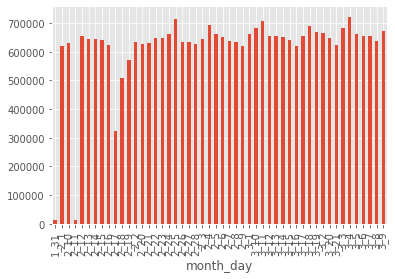

In [44]:
month_day = user_date_time.groupby('month_day')['month_day'].count()
month_day.plot(kind='bar')

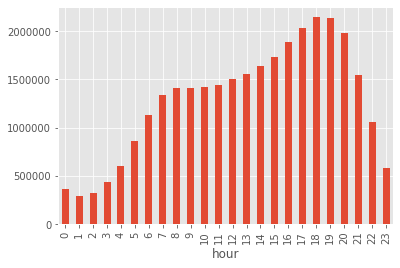

In [45]:
hours = user_date_time.groupby('hour')['hour'].count()
hours.plot(kind='bar')

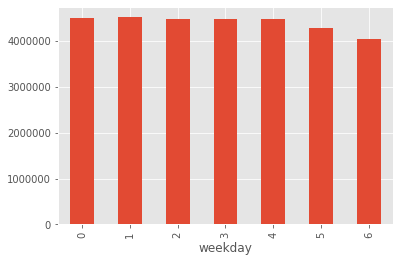

In [46]:
weekdays = user_date_time.groupby('weekday')['weekday'].count()
weekdays.plot(kind='bar')

In [47]:
client.cancel(user_date_time)
user_date_time = None
month_day = None
hours = None
weekdays = None

- каких-то существенных аномальных перекосов в пользовательской активности не выявлено
- видны недельные циклы пользовательской активности
- ожидалось что в даты близкие к 8 марта и 23 февраля могут быть какие нибудь аномальные активности, но эта гипотеза не подтвердилась

# <font color='blue'>Подготовка тренировочного и валидационного датасета

## Подготовка обучающего датасета

### Семплирование обучающего датасета
- Использовать весь датасет (31млн. строк) для обучения не рентабельно, поэтому просемплируем рандомно небольшую выборку размером с 1,5 млн записей

In [48]:
def dataset_random_sampling(dataset_directory, columns, sample_size=1500000):
    """Семплирование датасета из parquet файлов
    Случайная выборка указанного размера из parquet файлов 
    """
    print('Семплирование датасета')
    sampled_dataset = df(columns=columns)
    sample_size = sample_size//len(dataset_directory)

    for file in tqdm_notebook(train_col_dirs):
        sampled_dataset = pd.concat([sampled_dataset, pq.read_table(file+'/', columns=columns).to_pandas()\
                           .sample(n=sample_size, random_state=10)], ignore_index=True)
        
    return sampled_dataset

### Информация о частоте использования контента в процессе ваимодействия пользователя с ресурсом

- В данных содержится информация посещениях пользователя в разное время. 
- В разные моменты времени кол-во информации о посещенном и оцененном контенте разное. 
- Поскольку это может сильно влиять на точность модели - то это обстоятельство надо учесть и ввести переменную user_activity.

In [49]:
#добавляем перемнную учета пользовательской активности(кол-ва просмотренных обьектов) на текущий момент 
def add_user_activity(data):
    data['user_activity'] = 1
    data['user_activity'] = data.groupby('instanceId_userId')['user_activity'].cumsum()
    return data

### Разворачиваем вложенные признаки переменной 'metadata_options'

In [50]:
def nested_collections_encoding(data):
    """Разворачивание и кодирование вложенных коллекций
    - разворачивание: каждое значение вложеннного списка выносим в отдельную колонку
    - кодирование: подсчитываем сколько раз каждое значение признака повторялось в данной коллекции
    """
    metadata_dict = [Counter(x) for x in tqdm_notebook(data['metadata_options'])]
    data = df(metadata_dict).fillna(0).astype(int)
    return data, list(data.columns)

### Препроцессинг

In [51]:
def preprocessing(data):
    """Препроцессинг данных
    - сортируем данные по времени, для корректного учета пользовательской активности
    - рассчитываем и добавляем признак кол-ва посещений (счетчик с каждым посещением значение растет)
    - разворачивание и кодирование вложенных коллекций
    - замена пропущенных значений на 0
    """
    print('Препроцессинг датасета')
    #сортируем по времени
    data.sort_values(by=['audit_timestamp'], inplace=True)
    #добавляем пользовательскую активность
    data = add_user_activity(data)
    #бинаризация 'metadata_options'
    d , num_cols = nested_collections_encoding(data)
    num_cols += ['user_activity']
    data = pd.concat([data, d], axis=1)
    data.drop(['metadata_options'], axis=1,  inplace=True)
    data.fillna(0, inplace=True, downcast=False)
    ## Проверка
    assert data.isna().sum().sum() == 0
    
    return data, num_cols

In [52]:
columns = numeric_columns + category_columns + date_time_columns + id_columns + columns_with_nested_types
train_dataset = dataset_random_sampling(train_col_dirs, columns, sample_size=1500000)
train_dataset, meta_cols = preprocessing(train_dataset)
category_columns = category_columns + meta_cols
columns = numeric_columns + category_columns + date_time_columns + id_columns

Семплирование датасета



Препроцессинг датасета


In [53]:
## Рассчитываем таргет переменную, запоняем пропуски
target = train_dataset['feedback'].map(lambda x: 1 if 'Liked' in x else 0).values
train_dataset.drop(['feedback'], axis=1, inplace=True)

### Делим датасет на TRAIN и VALIDATION с балансировкой по классам
- в трейне и тесте должно оказаться приблизительно пропорциональное кол-во класса 1 и 0

% класса Liked  19.074466666666666


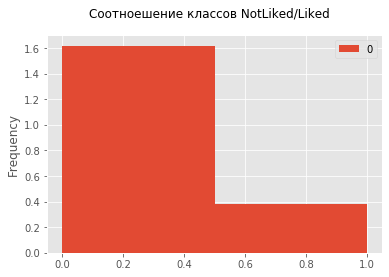

In [57]:
p = df(target).plot(kind='hist', subplots=True, sharex=True, sharey=True, title='Соотноешение классов NotLiked/Liked', bins=2, density=1)
print("% класса Liked " ,target.sum()/len(target)*100)

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_dataset, target, test_size=0.30, random_state=42, stratify=target)

X_train.reset_index(inplace=True)
X_valid.reset_index(inplace=True)

X_train = X_train.drop(['index'], axis=1)
X_valid = X_valid.drop(['index'], axis=1)

### Сериализуем данные для последующего обучения модели

In [59]:
def pickle_files(data, name):
    with open(name+'.pcl', 'wb') as f:
        pickle.dump(data, f)
        
pickle_files((X_train, y_train, numeric_columns, category_columns, date_time_columns, id_columns), 'train_dataset')
pickle_files((X_valid, y_valid), 'valid_dataset')

#убираем ссылки на обьекты для удаления интерпретатором
X_train, y_train, y_valid, train_dataset, target = None, None, None, None, None

In [66]:
import gc
gc.collect()

49

## Подготовка тестового датасета

In [61]:
test_dataset = pq.read_table(dataset_dir+'/test/').to_pandas(use_threads=8)
test_dataset.shape

(2671862, 106)

In [62]:
test_dataset, meta_cols = preprocessing(test_dataset)

Препроцессинг датасета


distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.84 GB -- Worker memory limit: 20.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.87 GB -- Worker memory limit: 20.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.88 GB -- Worker memory limit: 20.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.91 GB -- Worker memory limit: 20.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 14.87 GB -- Worker memory limit: 20.00 GB
distributed.wor

In [63]:
#непересекающиеся столбцы в 2-х датасетах
set(X_valid.columns)^set(test_dataset[columns].columns)

set()

In [65]:
pickle_files(test_dataset, 'test_dataset')

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 15.02 GB -- Worker memory limit: 20.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 15.02 GB -- Worker memory limit: 20.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 15.02 GB -- Worker memory limit: 20.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 15.02 GB -- Worker memory limit: 20.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 15.02 GB -- Worker memory limit: 20.00 GB
distributed.wor

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 15.02 GB -- Worker memory limit: 20.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 15.02 GB -- Worker memory limit: 20.00 GB
